In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import vmap, jit

from matplotlib import pyplot as plt
import os
import sys

from tqdm import tqdm

In [2]:
import model
import train

# Copy Task

## Problem

Given a repeating sequence of distinct tokens, continue the pattern. This equates to learning an induction head.

## Dataset Generation

The dataset consists of sequences of varying length that contain a repeating pattern and cut-off abruptly. The goal is to continue the sequence correctly. There is no semantic meaning behind tokens, so they can be randomly generated at init and frozen.

E.g. abcabcabca should be continued with bcabcabc

### Base case

The most simple case will simply have 64-character strings containing repeating character sequences of 4 to 15 distinct characters, so we see 8 to 4 repetitions. To start we can use 32 distinct tokens.

In [3]:
# # create dataset; we need to add masking on the loss function!
# key_d1 = jax.random.PRNGKey(0)

# dataset_name = 'copytask'
# token_arr = jnp.arange(128, dtype=jnp.uint16)
# sample_len = 64
# n_data = 2**19*3
# patt_min = 4
# patt_max = 15
# assert sample_len >= patt_max # so there is at least one repetition
# assert patt_max >= patt_min
# assert n_data % (patt_max-patt_min+1) == 0 # so each pattern length is represented equally

# pattern_inds = []
# masks = []
# for patt_len in range(patt_min, patt_max+1):
#   p = jnp.tile(jnp.arange(patt_len), 1+sample_len//patt_len)[:sample_len]
#   pattern_inds.append(p)
#   m = jnp.ones(sample_len)
#   m = m.at[:patt_len].set(0)
#   masks.append(m)
# pattern_inds = jnp.array(pattern_inds)
# masks = jnp.array(masks)

# key_gen, key_shuffle = jax.random.split(key_d1)
# key_perms = jax.random.split(key_gen, n_data)

# tok_permutations = vmap(lambda k : jax.random.permutation(k, token_arr))(key_perms)
# pattern_inds_expanded = jnp.tile(pattern_inds, (n_data//len(pattern_inds), 1))
# masks_expanded = jnp.tile(masks, (n_data//len(masks), 1))

# data = vmap(lambda i : tok_permutations[i][pattern_inds_expanded[i]])(jnp.arange(n_data))
# data_shuffled = data[jax.random.permutation(key_shuffle, jnp.arange(n_data))] # shuffle the data
# masks_shuffled = masks_expanded[jax.random.permutation(key_shuffle, jnp.arange(n_data))]
# print(pattern_inds.shape, pattern_inds_expanded.shape, masks_expanded.shape, data.shape)
# data_with_mask = jnp.concatenate([data_shuffled[None, ...], masks_shuffled[None, ...]], axis=0)
# print(data_with_mask.shape)
# val_data_len = n_data//16
# train_ids = np.array(data_with_mask, dtype=np.uint16)[:, :-val_data_len, :].reshape(2, -1)
# val_ids = np.array(data_with_mask, dtype=np.uint16)[:, -val_data_len:, :].reshape(2, -1)
# try:
#   os.mkdir(dataset_name)
# except:
#   print(f'dataset {dataset_name} already exists')
# train_ids.tofile(os.path.join(dataset_name, 'train_with_mask.bin'))
# val_ids.tofile(os.path.join(dataset_name, 'val_with_mask.bin'))

# sample_len, n_data, val_data_len

In [13]:
# create dataset; we need to add masking on the loss function!
key_d1 = jax.random.PRNGKey(0)

dataset_name = 'copytask'
token_arr = jnp.arange(64, dtype=jnp.uint16)
sample_len = 64
n_data = 2**19*3
patt_min = 4
patt_max = 27
assert sample_len >= patt_max # so there is at least one repetition
assert patt_max >= patt_min
assert n_data % (patt_max-patt_min+1) == 0 # so each pattern length is represented equally

tok_special = jnp.array([token_arr[0]]) # ensure these always map to inds 0
tok_ptr = token_arr[1:] # these are exchangeable, no semantic meaning
assert len(tok_ptr) >= patt_max

sample_inds = []
masks = []
for patt_len in range(patt_min, patt_max+1):
  pattern_inds = jnp.concatenate([jnp.arange(len(tok_special), patt_len+len(tok_special)), jnp.array([0])])
  p = jnp.tile(pattern_inds, 1+sample_len//patt_len)[:sample_len]
  sample_inds.append(p)
  m = jnp.ones_like(p)
  m = m.at[:len(pattern_inds)].set(0)
  masks.append(m)
sample_inds = jnp.array(sample_inds)
masks = jnp.array(masks)

key_gen, key_shuffle = jax.random.split(key_d1)
key_perms = jax.random.split(key_gen, n_data)

tok_permutations = vmap(lambda k : jnp.concatenate([tok_special, jax.random.choice(k, tok_ptr, shape=tok_ptr.shape)]))(key_perms)
pattern_inds_expanded = jnp.tile(sample_inds, (n_data//len(sample_inds), 1))
masks_expanded = jnp.tile(masks, (n_data//len(masks), 1))

data = vmap(lambda i : tok_permutations[i][pattern_inds_expanded[i]])(jnp.arange(n_data))
data_shuffled = data[jax.random.permutation(key_shuffle, jnp.arange(n_data))] # shuffle the data
masks_shuffled = masks_expanded[jax.random.permutation(key_shuffle, jnp.arange(n_data))]
data_with_mask = jnp.concatenate([data_shuffled[None, ...], masks_shuffled[None, ...]], axis=0)
val_data_len = n_data//16
train_ids = np.array(data_with_mask, dtype=np.uint16)[:, :-val_data_len, :].reshape(2, -1)
val_ids = np.array(data_with_mask, dtype=np.uint16)[:, -val_data_len:, :].reshape(2, -1)
try:
  os.mkdir(dataset_name)
except:
  print(f'dataset {dataset_name} already exists')
train_ids.tofile(os.path.join(dataset_name, 'train_with_mask.bin'))
val_ids.tofile(os.path.join(dataset_name, 'val_with_mask.bin'))

sample_len, n_data, val_data_len, train_ids.shape, val_ids.shape

dataset copytask already exists


(64, 1572864, 98304, (2, 94371840), (2, 6291456))

In [14]:
i = 0
train_ids[0][i*64:(i+1)*64], train_ids[1][i*64:(i+1)*64]

(array([28, 58, 45, 41, 16, 20, 40,  0, 28, 58, 45, 41, 16, 20, 40,  0, 28,
        58, 45, 41, 16, 20, 40,  0, 28, 58, 45, 41, 16, 20, 40,  0, 28, 58,
        45, 41, 16, 20, 40,  0, 28, 58, 45, 41, 16, 20, 40,  0, 28, 58, 45,
        41, 16, 20, 40,  0, 28, 58, 45, 41, 16, 20, 40,  0], dtype=uint16),
 array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       dtype=uint16))

In [15]:
# !rm -rf /content/logs

In [ ]:
# %%capture
config = train.TrainConfig(
    input_bin=f"{dataset_name}/train_with_mask.bin",
    input_val_bin=f"{dataset_name}/val_with_mask.bin",
    embd_dim = 128,
    head_dim = 64,
    n_layer = 2,
    block_size = sample_len, # should match the task sequence length so tasks are independently trained on
    batch_size = 64,
    gradient_accumulation_steps = 1,
    max_iters = 20_000,
    eval_iters = 25, # val_data_len // 64, # number of examples // batch_size
    learning_rate = 3e-3,
    min_lr = 1e-5,
    warmup_iters = 100,
    lr_decay_iters = 20_000,
    vocab_size = len(token_arr),
    use_masked_loss = True,
    use_mlp = False,
    off_by_one_attn = True,
    # freeze_params=("wte",),
    
    log_interval = 10_000,
    eval_interval = 1_000,
    # rope_base = 2**11,

)
display(config)

TrainConfig(mesh_axis_names=('dp',), mesh_shape=(4,), input_bin='copytask/train_with_mask.bin', input_val_bin='copytask/val_with_mask.bin', wandb_project='gpt-jax', wandb_entity=None, wandb_run_name=None, wandb_group=None, wandb_job_type=None, wandb_tags=(), wandb_notes=None, wandb_mode='online', wandb_log_code=True, max_iters=20000, warmup_iters=100, lr_decay_iters=20000, eval_interval=1000, eval_iters=25, log_interval=10000, save_every=0, batch_size=64, gradient_accumulation_steps=1, learning_rate=0.003, min_lr=1e-05, weight_decay=0.1, beta1=0.9, beta2=0.95, grad_clip=1.0, n_layer=2, embd_dim=128, head_dim=64, block_size=64, vocab_size=64, dropout=0.0, max_seq_len=2048, rope_base=10000.0, use_mlp=False, off_by_one_attn=True, seed=1337, use_masked_loss=True, freeze_params=('wte',))

In [23]:
params = train.train_loop(config)

[wandb] No credentials found. Falling back to offline mode.


wandb: Number of parameters: 0.14M
wandb: Parameter freezing enabled: 8,192 frozen, 131,456 trainable
wandb: Freeze patterns: ('wte',)
wandb: Loading training data...
wandb: Process 0/1 prepared dataset from 1 file(s): 94,371,840 tokens, 0.38 GB on disk.
wandb: Process 0/1 prepared loader with 20000 batches.
wandb: Loaded 20000 training batches.
wandb: Loading validation data...
wandb: Process 0/1 prepared dataset from 1 file(s): 6,291,456 tokens, 0.03 GB on disk.
wandb: Process 0/1 prepared loader with 25 batches.
wandb: Loaded 25 validation batches.
wandb: Starting Ahead-of-Time (AOT) compilation...


Number of parameters: 0.14M
Parameter freezing enabled: 8,192 frozen, 131,456 trainable
Freeze patterns: ('wte',)
Loading training data...
Process 0/1 prepared dataset from 1 file(s): 94,371,840 tokens, 0.38 GB on disk.
Process 0/1 prepared loader with 20000 batches.
Loaded 20000 training batches.
Loading validation data...
Process 0/1 prepared dataset from 1 file(s): 6,291,456 tokens, 0.03 GB on disk.
Process 0/1 prepared loader with 25 batches.
Loaded 25 validation batches.
Starting Ahead-of-Time (AOT) compilation...


wandb: AOT compilation finished.
wandb: Starting training...
wandb: Running validation for step 0...


AOT compilation finished.
Starting training...
Running validation for step 0...
model/total_params: 139392 | model/attn_params: 131072 | model/mlp_params: 0 | model/embed_params: 8192 | model/vocab_size: 64 | val_loss: 4.256 | step: 0 | lr: 0 | loss: 4.27


wandb: Running validation for step 1000...


Running validation for step 1000...
val_loss: 1.854


wandb: Running validation for step 2000...


Running validation for step 2000...
val_loss: 1.819


wandb: Running validation for step 3000...


Running validation for step 3000...
val_loss: 1.815


wandb: Running validation for step 4000...


Running validation for step 4000...
val_loss: 1.81


wandb: Running validation for step 5000...


Running validation for step 5000...
val_loss: 1.815


wandb: Running validation for step 6000...


Running validation for step 6000...
val_loss: 1.805


wandb: Running validation for step 7000...


Running validation for step 7000...
val_loss: 1.806


wandb: Running validation for step 8000...


Running validation for step 8000...
val_loss: 1.801


wandb: Running validation for step 9000...


Running validation for step 9000...
val_loss: 1.797


wandb: Running validation for step 10000...


Running validation for step 10000...
val_loss: 1.797 | step: 10000 | lr: 0.001517 | loss: 1.8


wandb: Running validation for step 11000...


Running validation for step 11000...
val_loss: 1.797


wandb: Running validation for step 12000...


Running validation for step 12000...
val_loss: 1.795


wandb: Running validation for step 13000...


Running validation for step 13000...
val_loss: 1.794


wandb: Running validation for step 14000...


Running validation for step 14000...
val_loss: 1.792


wandb: Running validation for step 15000...


Running validation for step 15000...
val_loss: 1.791


wandb: Running validation for step 16000...


Running validation for step 16000...
val_loss: 1.79


wandb: Running validation for step 17000...


Running validation for step 17000...
val_loss: 1.79


wandb: Running validation for step 18000...


Running validation for step 18000...
val_loss: 1.79


wandb: Running validation for step 19000...


Running validation for step 19000...
val_loss: 1.79


wandb: Final validation...
wandb: Running validation for step 19999...
wandb: Training finished.
wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.
wandb: Saved checkpoint to logs/tbp6eifk//state_step019999.pkl


Final validation...
Running validation for step 19999...
step: 19999 | val_loss: 1.79
Training finished.
Saved checkpoint to logs/tbp6eifk//state_step019999.pkl


loss,█▁
lr,▁█
model/attn_params,▁
model/embed_params,▁
model/mlp_params,▁
model/total_params,▁
model/vocab_size,▁
step,▁▅█
val_loss,█▄▄▃▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁
loss,1.80018
lr,0.00152


In [24]:
test_input = [3,9,8,3,4,4,4,8,5,8,6,6,8,8,7] + [0]
patt_len = len(test_input)
print('patt_len', patt_len)
res = list(test_input)
start_len = len(res)

rope_params = model.precompute_rope(config.get_model_config(), None)
# test on 2x the sample length
for i in tqdm(range(start_len, int(2*sample_len)+1)):
  padded_test_input = res + [0]*(sample_len - len(res))
  preds = model.gpt_forward(params, rope_params,jnp.array(res)[None,:], config.get_model_config())
  new_ind = jnp.argmax(preds[0][i])
  res.append(new_ind.item())

patt_len 16


100%|██████████| 113/113 [00:03<00:00, 33.20it/s]


<BarContainer object of 64 artists>

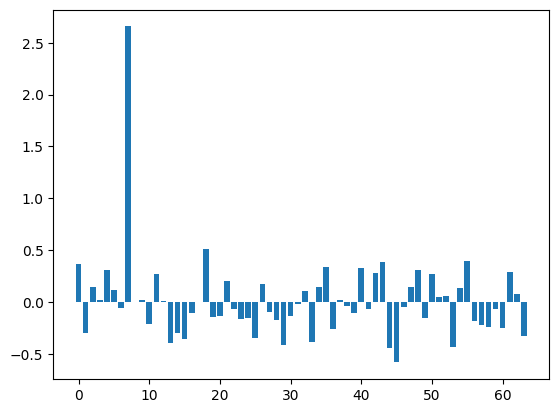

In [25]:
plt.bar(jnp.arange(len(preds[0][45])), preds[0][45])

In [26]:
res = jnp.array(res)

print("Testing input:")
print(jnp.array(test_input)[:patt_len])

print("Predicted output:")
for l in res[patt_len: len(res) - (len(res)%patt_len)].reshape(-1, patt_len):
    print(l)

Testing input:
[3 9 8 3 4 4 4 8 5 8 6 6 8 8 7 0]
Predicted output:
[3 9 8 3 4 4 4 8 5 8 6 6 8 8 7 0]
[3 9 8 3 4 4 4 8 5 8 6 6 8 8 7 0]
[3 9 8 3 4 4 4 8 5 8 6 6 8 8 7 0]
[3 9 8 3 4 4 4 4 4 4 4 8 5 8 6 6]
[8 8 8 7 0 3 9 8 3 4 4 4 4 4 4 4]
[4 4 8 8 8 8 8 0 3 0 3 0 3 0 3 4]
[0 3 4 4 8 0 3 8 4 8 0 3 0 3 0 3]


# Path Graph

## Problem

Given a 'goal' token, identify which unique 'path' in context it comes from and return all tokens in the path up to and including the goal.

Concretely, suppose your context has two paths: A,B,C and P,Q,R,S. Given a goal R, we would return P,Q,R. This tests the model's ability to build pointers between tokens based on context.

## Dataset Generation

The dataset consists of a list of sequences. Sequences can be one of three types:
- context
- input
- output

No nesting of sequences is allowed.

#### Tokenization

Overall will use 128 tokens.

Special Tokens (with index):
- Context Start: 0
- Input Start: 1
- Output start: 2

Each special token implicitly ends the previous sequence and starts a new one. These embeddings can be learned.

All remaining tokens are exchangeable, i.e. only act as pointers and contain no semantic meaning. Their embeddings will be fixed and initialized randomly.

1. Minimal example
- 0, 3,4,5,6, 1, 5, 2, 3,4,5

2. Two contexts
- 0, 3,4,5,6, 0, 7,8,9, 1, 4, 2, 3,4

3. Stream of problems (context grows and problems arrive independently)
- 0, 3,4,5,6, 0, 7,8,9, 1, 5, 2, 3,4,5, 0, 10,11,12,13,14, 1, 4, 2, 3,4, 1, 12, 2, 10,11,12

For position encoding we'll use RoPE which works well with QK-norm attention.

In [27]:
# TBD, need to add masking to loss_fn()!